In [50]:
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from bertopic import BERTopic
from textblob import TextBlob

In [51]:
df = pd.read_csv('../datasets/tweets_generated.csv', header=None)
df.columns = ['category', 'sentiment', 'text']
df

,category,sentiment,text
0,healthcare,very_positive,I am constantly amazed by the high quality of ...
1,healthcare,slightly_positive,The healthcare system in the Czech Republic ma...
2,healthcare,very_positive,I am constantly amazed by the top-notch health...
3,healthcare,slightly_positive,"Despite some challenges, I am impressed by the..."
4,healthcare,very_positive,Proud to see the Czech Republic's healthcare s...
5,healthcare,slightly_positive,Appreciating the improvements made in Czech he...
6,healthcare,very_positive,I am so grateful for the excellent and afforda...
7,healthcare,very_positive,I am so grateful for the incredible healthcare...
8,healthcare,very_positive,I am so grateful for the exceptional healthcar...
9,healthcare,very_negative,Healthcare in the Czech Republic is an absolut...


In [52]:
nltk.download('stopwords')
texts_clean = df['text']

replacements = [
    ("it's", "it is"),
    ("#", ''),
    (r"[^\w\s]", ''),
    (r"\s+", ' '),
    ('dont', 'do not'),
    ('im', 'i am'),
    ('theres', 'there is'),
    ('thats', 'that is'),
    ('youre', 'you are'),
    ('doesnt', 'does not'),
    ('didnt', 'did not'),
    ('cant', 'can not'),
    ('couldnt', 'could not')
]

for replacement in replacements:
    texts_clean = [re.sub(replacement[0], replacement[1], t) for t in texts_clean]

stopwords_en = nltk.corpus.stopwords.words('english')
texts_no_sw = [' '.join([w for w in t.split() if w not in stopwords_en])
               for t in texts_clean if 'holytrainer' not in t]
len(texts_no_sw)

[nltk_data] Downloading package stopwords to /home/milos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


17

In [69]:
topic_model = BERTopic(
    language='english', top_n_words=3, n_gram_range=(1, 2), 
    min_topic_size=3, nr_topics=2, calculate_probabilities=True, verbose=False)
topic_model.fit(texts_no_sw)
print(topic_model.get_topics())
print(len(topic_model.probabilities_))

{0: [('education', 0.07797086575959138), ('outdated', 0.07093130732572951), ('czech', 0.06643417259671021)], 1: [('healthcare', 0.09825901655001672), ('czech', 0.08358738390459057), ('czech republic', 0.07736499046823568)]}
17


In [93]:
topic_model.probabilities_.sum(axis=0)

pd.options.display.float_format = "{:,.4f}".format
pd.DataFrame(topic_model.probabilities_)

,0,1
0,0.1181,0.8283
1,0.0000,1.0000
2,0.0000,1.0000
3,0.1421,0.8303
4,0.1371,0.7408
5,0.1520,0.6860
6,0.0000,1.0000
7,0.1192,0.7586
8,0.1259,0.8668
9,0.2209,0.4648


In [99]:
sentiments = []
mask = []

for t in df['text']:
    if 'holytrainer' in t.lower():
        continue
    polarity = TextBlob(t).sentiment.polarity
    sentiments.append(polarity)
    if abs(polarity) < 0.05:
        mask.append([0])
    else:
        mask.append([1])

sentiments = np.array(sentiments).reshape(-1, 1)
sentiments

#df['sentiments'] = sentiments
# df.groupby('sentiment').mean('sentiments')

array([[ 0.30533333],
       [ 0.11363636],
       [ 0.42      ],
       [ 0.31944444],
       [ 0.585     ],
       [ 0.        ],
       [ 0.66666667],
       [ 0.66666667],
       [ 0.33333333],
       [ 0.14166667],
       [-0.38333333],
       [-0.06666667],
       [ 0.15833333],
       [ 0.034375  ],
       [ 0.034375  ],
       [ 0.14204545],
       [ 0.06      ]])

In [64]:
mean_sentiments = (sentiments * topic_model.probabilities_).sum(axis=0) / np.array(mask).sum(axis=0)
mean_sentiments[:5]

array([0.03763578, 0.21084659])

In [57]:
def semivariance(data, mean: np.ndarray, probas: np.ndarray, side):
    semivariances = []
    for i in range(len(mean)):
        if side == 'left':
            semi_data = data[data < mean[i]]
            semi_probas = probas[(data < mean[i]).reshape(-1), i]
        else:
            semi_data = data[data > mean[i]]
            semi_probas = probas[(data > mean[i]).reshape(-1), i]
        nominator = (((semi_data - mean[i]) ** 2) * semi_probas).sum(axis=0)
        denominator = semi_probas.sum(axis=0)
        result = np.sqrt(nominator / denominator)
        semivariances.append(result)
    return semivariances

In [65]:
semivariance_left = semivariance(sentiments, mean_sentiments, topic_model.probabilities_, 'left')
semivariance_right = semivariance(sentiments, mean_sentiments, topic_model.probabilities_, 'right')

semivariance_left, semivariance_right

([0.09427121797204754, 0.30139992782237024],
 [0.1538092487753492, 0.30502015087553425])

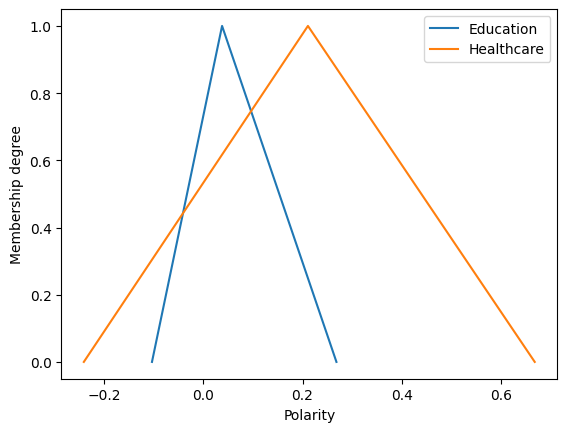

In [98]:
plt.plot([mean_sentiments[0] - semivariance_left[0] * 1.5, mean_sentiments[0], mean_sentiments[0] +
          semivariance_right[0] * 1.5], [0, 1, 0], label='Education')
plt.plot([mean_sentiments[1] - semivariance_left[1] * 1.5, mean_sentiments[1], mean_sentiments[1] +
          semivariance_right[1] * 1.5], [0, 1, 0], label='Healthcare')
plt.xlabel('Polarity')
plt.ylabel('Membership degree')
plt.legend()
plt.show()

In [66]:
def conformity_positive(answer_fuzzy, neg_a, neg_b):
    if answer_fuzzy[1] >= neg_b:
        possibility = 1
    elif answer_fuzzy[2] <= neg_a:
        possibility = 0
    else:
        x = (neg_a * answer_fuzzy[1] - answer_fuzzy[2] * neg_b) / \
            (neg_a - neg_b + answer_fuzzy[1] - answer_fuzzy[2])
        possibility = (x - neg_a) / (neg_b - neg_a)
    return possibility


def conformity_negative(answer_fuzzy, pos_a, pos_b):
    answer_fuzzy_rev = (- answer_fuzzy[2], - answer_fuzzy[1], - answer_fuzzy[0])
    return conformity_positive(answer_fuzzy_rev, pos_b, pos_a)



In [67]:
con_pos = conformity_positive([mean_sentiments[0] - semivariance_left[0] * 1.5, mean_sentiments[0], mean_sentiments[0] +
                               semivariance_right[0] * 1.5], -0.32, 1)
con_neg = conformity_negative([mean_sentiments[0] - semivariance_left[0] * 1.5, mean_sentiments[0], mean_sentiments[0] +
                               semivariance_right[0] * 1.5], 1, -0.75)
con_pos, con_neg

(0.3794056780253503, 0.45139471819686283)

In [68]:
con_pos = conformity_positive([mean_sentiments[1] - semivariance_left[1] * 1.5, mean_sentiments[1], mean_sentiments[1] +
                               semivariance_right[0] * 1.5], -0.32, 1)
con_neg = conformity_negative([mean_sentiments[1] - semivariance_left[0] * 1.5, mean_sentiments[1], mean_sentiments[1] +
                               semivariance_right[1] * 1.5], 1, -0.75)
con_pos, con_neg


(0.49110314886735434, 0.35981694911875756)